In [1]:
# Demo for visualisation of crop type and yield data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#3D stuff
from IPython.core.display import display, HTML
import json

import geopandas as gpd
import geojson
import pandas as pd

from functools import partial
from shapely.geometry import Point # Point class
from shapely.geometry import shape # shape() is a function to convert geo objects through the interface

#!pip install matplotlib
import matplotlib.pyplot as plt

Example for yield data

In [2]:
#spatial field yield data from a combine harvester
yields = pd.read_csv('../data/cropdata/Bavaria/yields/yields2018.csv', sep=",",encoding = "ISO-8859-1", engine='python')
yields = yields[['Name','Latitude', 'Longitude', 'Elevation(m)','Ertr.masse (Nass)(tonne/ha)','Ertr.masse (Tr.)(tonne/ha)','Ertr.vol (Tr.)(L/ha)', 'ErtragNass', 'ErtragTr', 'Feuchtigkeit(%)', 'Jahr','TAG' ]]

# linear interpolated on a weekly basis for winter wheat
training = pd.read_excel("../data/cropdata/Bavaria/yields/result_split_S2A_linear_W_WW_2018.xlsx")
#not interpolated daily data/ weather is daily 
daily_training = pd.read_excel("../data/cropdata/Bavaria/yields/satellite_data_orginal.xlsx")
# summary with nitrogen, yield and polygon ..."field-level yield in dt/ha !"
summary = pd.read_excel("../data/cropdata/Bavaria/yields/fields_summary.xlsx")

1D timeseries

/tmp/ipykernel_1550/2091479612.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field['Polygon'] = gpd.GeoSeries.from_wkt(field['Polygon'])


<AxesSubplot:>

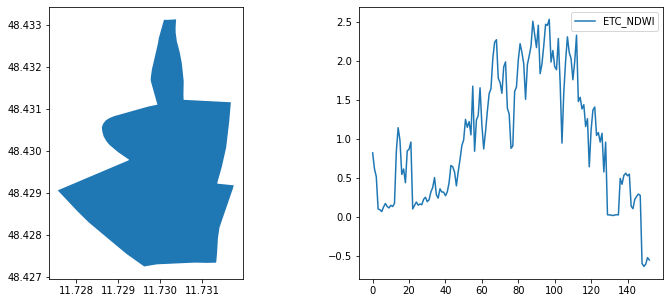

In [35]:
# plot one field and the corresponding 1D timeseries
# The dataset includes daily water needs, raw bands, indices, weather etc.

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 5))
daily_training[daily_training.Name == 'Baumacker'][['ETC_NDWI']].plot(ax=ax2)
field = summary[summary.Name == 'Baumacker']
field['Polygon'] = gpd.GeoSeries.from_wkt(field['Polygon'])
gdf = gpd.GeoDataFrame(field, geometry='Polygon')
gdf.plot(ax=ax1)


Pixel-based yield and satellite data

/workspace/.pip-modules/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


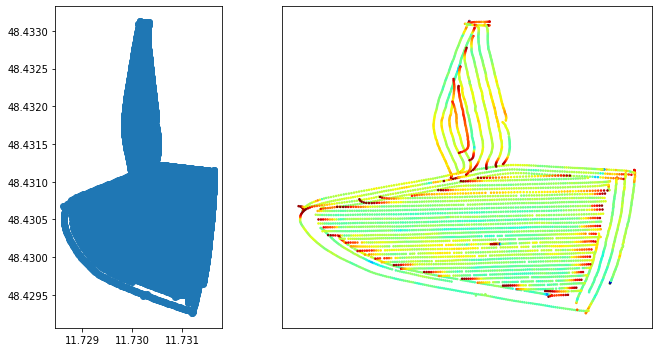

In [40]:
#plot the corresponding combine harvester data for the same field
from shapely.geometry import Point

f, (ax1,ax2) = plt.subplots(1, 2,figsize=(10, 5))

size=40

field = yields[yields.Name == 'Baumacker']
geometry = [Point(xy) for xy in zip(field.Longitude, field.Latitude)]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(field, crs=crs, geometry=geometry)

minx, miny, maxx, maxy = gdf.total_bounds

ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.scatter(y=field.Latitude, x=field.Longitude, alpha=1,cmap=plt.get_cmap("jet_r"), c=field['Ertr.masse (Nass)(tonne/ha)'],s=2.2)
gdf.plot(ax=ax1)
f.tight_layout() 

plt.show()

In [41]:
# and now lets explore the corresponding sentinel-2 timeseries (L2A) for the combine harvester data
!pip install rasterio
import rasterio as rio
from tqdm.auto import tqdm
tqdm.pandas()

     |████████████████████████████████| 19.2 MB 8.8 MB/s 
You should consider upgrading via the '/home/gitpod/.pyenv/versions/3.8.12/bin/python3 -m pip install --upgrade pip' command.


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


<AxesSubplot:title={'center':'blue channel'}>

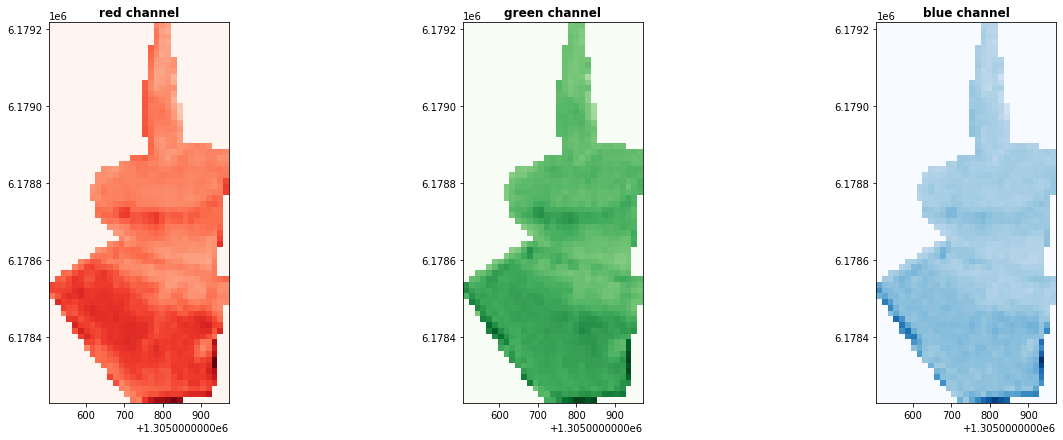

In [52]:
#every image has 
fp1 = '../data/cropdata/Bavaria/yields/sat_images_10m/Baumacker/01a0c00ccb65ec1618c82ec40cd78ce1/response.tiff'
fp2 = '../data/cropdata/Bavaria/yields/sat_images_10m/Baumacker/28f87c250b090e2436505b0db2931e90/response.tiff'
fp3 = '../data/cropdata/Bavaria/yields/sat_images_10m/Baumacker/f99a4ff29ac6917833a1b427344d00a6/response.tiff'

raster1 = rio.open(fp1)
raster2 = rio.open(fp2)
raster3 = rio.open(fp3)

from rasterio.plot import show

# data description: 
# ["CLM", "dataMask", "B01", "B02", "B03", "B04","B05", "B06","B07", "B08","B8A", "B09", "B11","B12"]

fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show((raster1, 6), ax=axr, cmap='Reds', title='red channel')
show((raster1, 5), ax=axg, cmap='Greens', title='green channel')
show((raster1, 4), ax=axb, cmap='Blues', title='blue channel')




In [109]:
def plot(image, factor=1, _min=0, _max=1):
    """
    visualize satellite images
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1), vmin=_min, vmax=_max)
    else:
        plt.imshow(image, vmin=_min, vmax=_max)


with rio.open(fp1, 'r') as ds:
    arr3 = ds.read() 

In [57]:
# every image has 19 bands with 66 x 31 pixels
# time_interval:'2018-03-01' - '2018-07-30' 
# Level L2A
# Winter Wheat: 'Baumacker', 'D8', 'Dichtlacker', 'Heindlacker', 'Heng', 'Holzacker', 'Neulandsiedlung', 'Itzling2', 'Itzling5',
# 'Itzling6', 'Schluetterfabrik','Thalhausen138', 'Thalhausen141', 'Voettingerfeld'
# 
# Image bands:
# ["CLM", "dataMask", "B01", "B02", "B03", "B04","B05", "B06","B07", "B08","B8A", "B09", "B11","B12", sunAzimuthAngles, sunZenithAngles, viewAzimuthMean, viewZenithMean, NDWI]
# CLM stands for clouds 1 / no clouds 0
# there are also meta information and an index 
arr3.shape

(19, 66, 31)

In [110]:
import numpy as np
arr3 = np.moveaxis(arr3, 0, -1)
arr3.shape

(66, 31, 19)

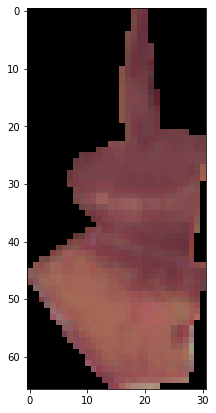

In [111]:
plot(arr3[:, :, [6, 5, 4]],4.5)